Axios [reported](https://www.axios.com/coronavirus-global-economic-risk-stock-market-china-24da74a5-c824-4c79-a8c7-220213d28824.html) a few weeks back on growing concern from economists about the understated risks to the global economy posed by coronavirus. The report cites an interesting statistic about the attention paid to coronavirus on recent earnings calls:

> Of the 364 companies that have held Q4 earnings calls, 138 cited the term "coronavirus" during the call, and about 25% of those included some impact from the coronavirus or modified guidance due to the virus, according to FactSet.

Additionally, the author cites a [note](https://www.guggenheiminvestments.com/perspectives/global-cio-outlook/coronavirus-impact-on-the-global-economy) in which Scott Minerd, global CIO of Guggenheim Investments, compares the "cognitive dissonance" of market participants to the assurances given by Neville Chamberlain to Britain on the eve of World War II.

These fears materialized shortly after as markets crashed and continue to crash. My mind came back to this statistic, so I pulled the transcripts and started analyzing.

## Data Acquisition

The Motley Fool provides earnings call transcripts for the companies that they cover in a [centralized place](https://www.fool.com/earnings-call-transcripts/), making it quite easy to scrape and parse. Global media outlets picked up the story in early January, so I pulled transcripts from all earnings calls occurring in 2020 (as of February 29th). This leaves us with data on 2,277 unique earnings calls.

The transcripts all follow a standardized structure, so I parse the data out according to their logical sections. A sample fully parsed document is shown below. The most relevant fields for this analysis are the prepared remarks section and the Q&A section which hold the relevant transcribed text from the call.

In the analysis that follows, I say that an earnings call "discusses the outbreak" or "mentions the coronavirus" if it contains either the term "coronavirus" or "covid".

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import datapackage
import re
import numpy as np
from nltk.tokenize import sent_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
plt.style.use("fivethirtyeight")

# read the earnings calls, convert dates, and drop any where the original
# date of the call was before 2020 (or wasn't able to be parsed)
df = pd.read_csv("data/earnings_calls.csv")
df.fillna("", inplace=True)
df["date"] = pd.to_datetime(df.date)
df = df[~df.date.isna() & (df.date >= "2020-01-01")]

# find which ones mention coronavirus
_has_coronavirus = lambda x: re.search(r"(coronavirus)|(covid)", x, re.I) is not None
df["prepared_remarks_cv"] = df.prepared_remarks.apply(_has_coronavirus)
df["questions_and_answers_cv"] = df.questions_and_answers.apply(_has_coronavirus)
df["any_cv"] = df.prepared_remarks_cv | df.questions_and_answers_cv

# strip out quarter
df["quarter"] = df.title.apply(lambda x: re.search(r"Q(1|2|3|4)", x).group(0))

# order by date
df = df.sort_values("date").reset_index(drop=True)

# obtain sector data for S&P 500 companies from https://datahub.io/core/s-and-p-500-companies
sector_data = pd.read_csv("data/s_and_p_sectors.csv")

# join in sector data for S&P 500 companies
df["ticker_split"] = df.ticker.apply(lambda x: x.split(":")[1])
df = pd.merge(df, sector_data, how="left", left_on="ticker_split", right_on="Symbol")

## Rising Concern

Unsurprisingly, discussion of the outbreak and its impact in earnings calls has been steadily rising, starting in the last week of January. About half of calls in this dataset mention coronavirus.

This number, however, is heavily dependent on the chosen time range. Measured as a cumulative proportion over time, it continues to climb, and the (noisy) proportion on any given day in recent weeks hovers near 100%.

In [2]:
df.shape

(2788, 20)

In [3]:
df.head()

,url,title,author,transcribed_date,description,top,prepared_remarks,questions_and_answers,call_participants,name,ticker,date,prepared_remarks_cv,questions_and_answers_cv,any_cv,quarter,ticker_split,Symbol,Name,Sector
0,https://www.fool.com/earnings/call-transcripts...,Resources Connection Inc (RECN) Q2 2020 Earnin...,Motley Fool Transcribers,"Jan 2, 2020",RECN earnings call for the period ending Novem...,Image source: The Motley Fool.\n\nResources Co...,"Operator\n\nGood afternoon, ladies and gentlem...",Operator\n\n[Operator Instructions]. Our first...,Alice Washington -- General Counsel\n\nKate Du...,Resources Connection Inc,NASDAQ:RECN,2020-01-02,False,False,False,Q2,RECN,NaN,NaN,NaN
1,https://www.fool.com/earnings/call-transcripts...,Landec Corp (LNDC) Q2 2020 Earnings Call Trans...,Motley Fool Transcribers,"Jan 3, 2020",LNDC earnings call for the period ending Novem...,Image source: The Motley Fool.\n\nLandec Corp ...,Operator\n\nGood morning and thank you for joi...,Operator\n\nThank you. We will now be conducti...,Albert Bolles -- Chief Executive Officer\n\nBr...,Landec Corp,NASDAQ:LNDC,2020-01-03,False,False,False,Q2,LNDC,NaN,NaN,NaN
2,https://www.fool.com/earnings/call-transcripts...,"Lamb Weston Holdings, Inc. (LW) Q2 2020 Earnin...",Motley Fool Transcribers,"Jan 3, 2020",LW earnings call for the period ending Novembe...,Image source: The Motley Fool.\n\nLamb Weston ...,"Operator\n\nGood day, and welcome to the Lamb ...",Operator\n\nThank you. (Operator Instructions)...,Dexter Congbalay -- Vice President-Investor Re...,"Lamb Weston Holdings, Inc.",NYSE:LW,2020-01-03,False,False,False,Q2,LW,NaN,NaN,NaN
3,https://www.fool.com/earnings/call-transcripts...,Commercial Metals Company (CMC) Q1 2020 Earnin...,Motley Fool Transcribing,"Jan 6, 2020",CMC earnings call for the period ending Decemb...,Image source: The Motley Fool.\n\nCommercial M...,"Operator\n\nHello, and welcome, everyone, to t...",Operator\n\n[Operator instructions] Our first ...,"Barbara Smith -- Chairman of the Board, Presid...",Commercial Metals Company,NYSE:CMC,2020-01-06,False,False,False,Q1,CMC,NaN,NaN,NaN
4,https://www.fool.com/earnings/call-transcripts...,EXFO Inc (EXFO) Q1 2020 Earnings Call Transcript,Motley Fool Transcribers,"Jan 7, 2020",EXFO earnings call for the period ending Novem...,Image source: The Motley Fool.\n\nEXFO Inc (NA...,"Operator\n\nGood day everyone, welcome to EXFO...",Operator\n\nThank you. [Operator Instructions]...,Vance Oliver -- Investor Relations\n\nPhilippe...,EXFO Inc,NASDAQ:EXFO,2020-01-07,False,False,False,Q1,EXFO,NaN,NaN,NaN


In [4]:
df.any_cv.mean()

0.460545193687231

In [5]:
cumulative_proportion = df.any_cv.cumsum() / (df.index.values + 1)
cum_prop = pd.Series(cumulative_proportion.values, index=df.date, name="cumprop")
by_day = df.groupby("date").mean()["any_cv"]
cc = pd.concat([by_day, cum_prop], axis=1)

/Users/lukelefebure/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


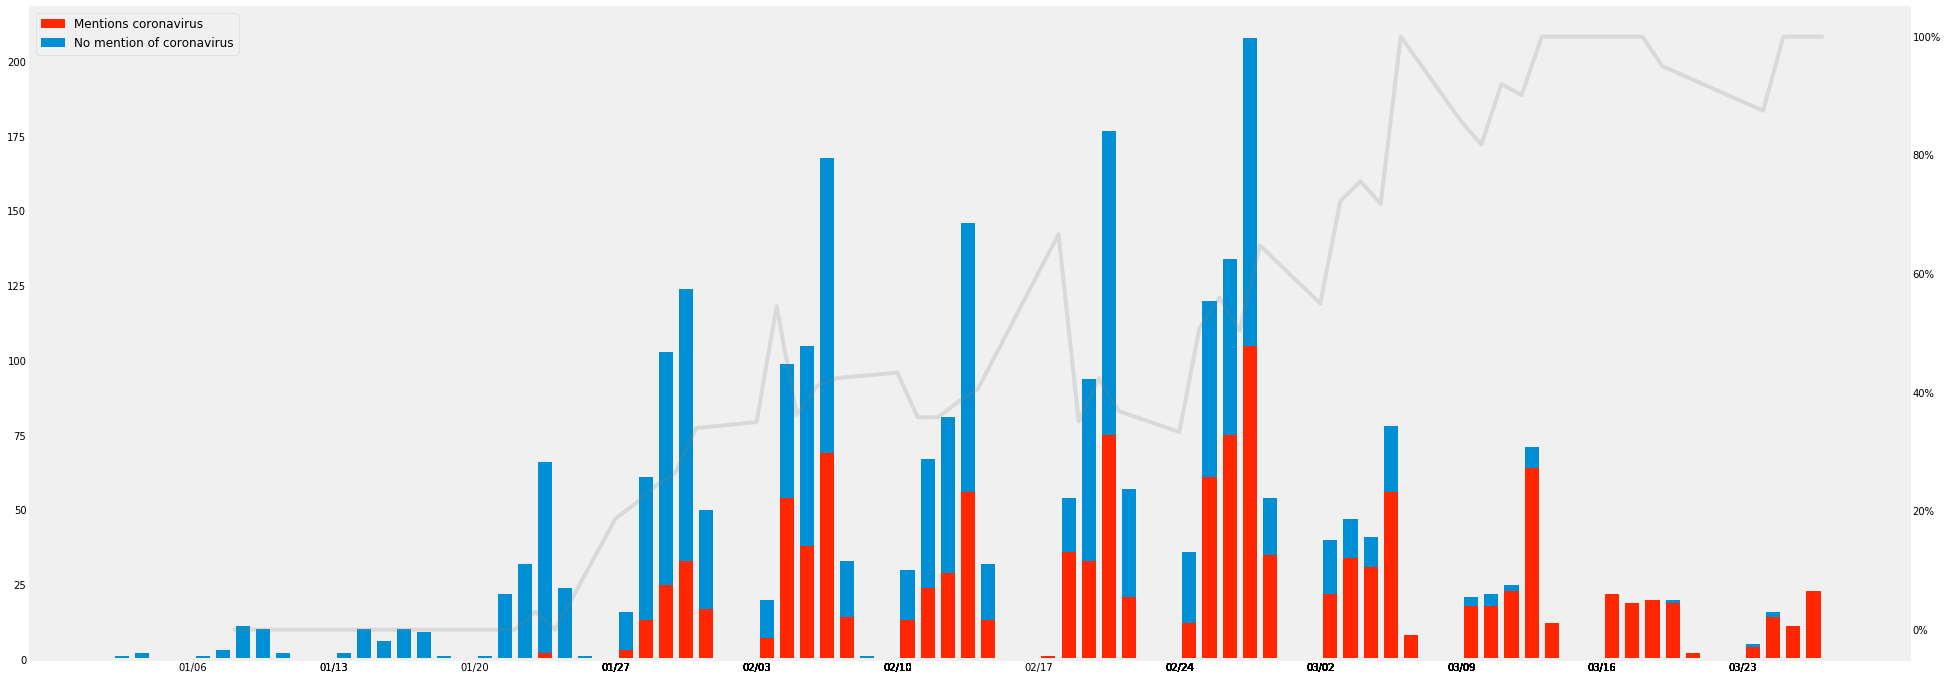

In [6]:
plt.figure(figsize=(30,12))
ax = plt.axes()
ax.hist(
    [df.date[df.any_cv], df.date[~df.any_cv]],
    bins=(df.date.max() - df.date.min()).days,
    stacked=True,
    color=["#FF2700", "#008FD5"],
    label=["Mentions coronavirus", "No mention of coronavirus"],
    rwidth=0.7
)
ax.legend(loc="upper left", fontsize="large")
ax.grid(False)
ax2 = ax.twinx()
ax2.grid(False)
# The df.groupby("date").size() > 5 below is to filter out the outliers
ax2.plot(cc["any_cv"][df.groupby("date").size() > 5], color="grey", alpha=0.2)
ticks = np.arange(0, 1.1, .2)
plt.yticks(ticks=ticks, labels=[f"{int(100 * t)}%" for t in ticks])
xticks = cc.index[pd.Series(cc.index).apply(lambda x: x.dayofweek == 0).values]
plt.xticks(ticks=xticks, labels=[t.strftime("%m/%d") for t in xticks]);
# plt.savefig("graph.svg")

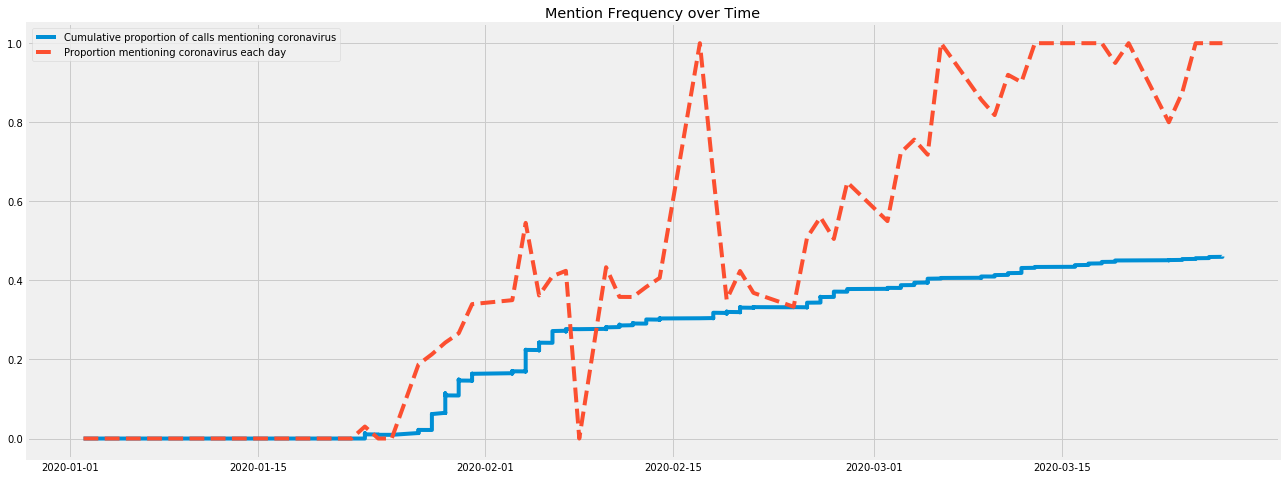

In [8]:
plt.figure(figsize=(20,8))
plt.plot(cc["cumprop"], label="Cumulative proportion of calls mentioning coronavirus")
plt.plot(cc["any_cv"], linestyle="--", label="Proportion mentioning coronavirus each day")
plt.title("Mention Frequency over Time")
plt.legend();

## Across Sectors

To better understand where most attention, I pulled metadata for S&P 500 companies and joined that with the earnings call dataset. This leaves us with sector level data for the 406 S&P 500 companies in the earnings call dataset.

Service sectors such as Financials and Utilities appear be the most immune, however this may be a red herring since Financials, for example, are stacked towards the beginning of the year when it was less of an issue.

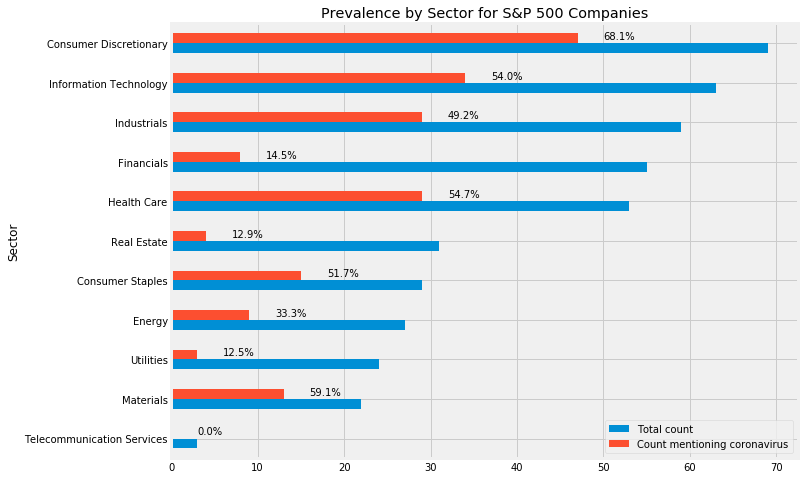

In [9]:
counts_by_sector = df.groupby("Sector").agg(["size", "sum"])["any_cv"].sort_values("size")
ax = counts_by_sector.plot(
    kind="barh",
    figsize=(10, 8),
    title="Prevalence by Sector for S&P 500 Companies"
)
for i, (_, row) in enumerate(counts_by_sector.iterrows()):
    ax.text(row["sum"] + 3, i + .1, "{:.1f}%".format(100 * row["sum"] / row["size"]))
ax.legend(["Total count", "Count mentioning coronavirus"]);

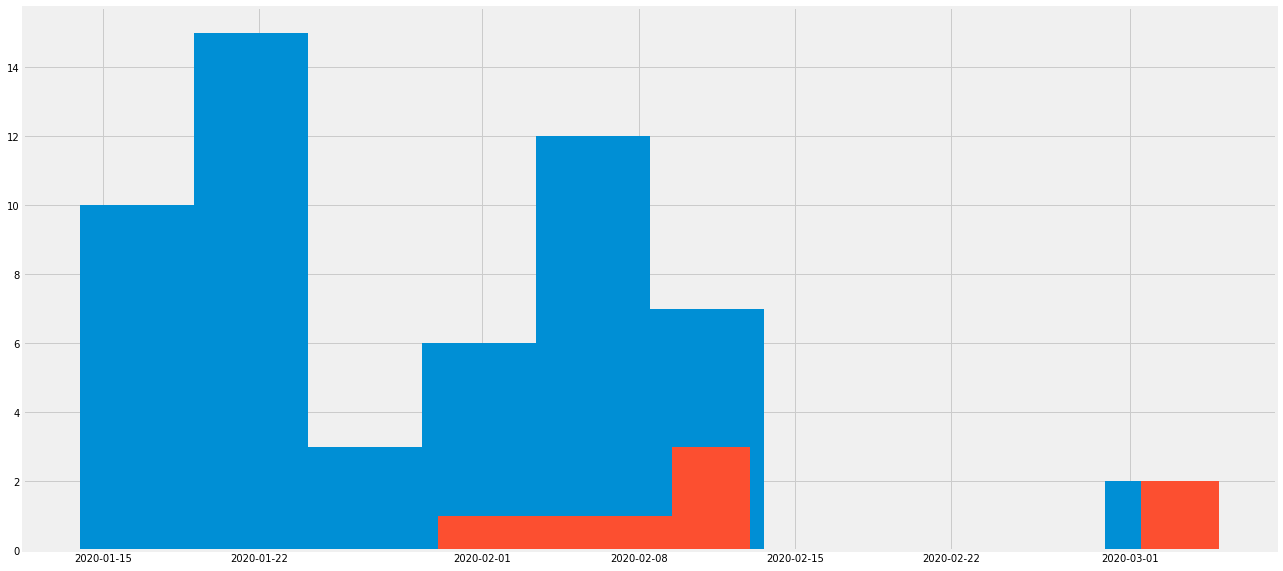

In [89]:
# Financials stacked towards beginning of year. Time confounds the graph above.
sec = "Financials"
plt.figure(figsize=(20, 10))
df[df.Sector == sec].date.hist()
df[(df.Sector == sec) & df.any_cv].date.hist();

## Who was first

In [136]:
print(df[df.ticker.apply(lambda x: "AAPL" in x)].loc[251].prepared_remarks)

Operator

Good day everyone. Welcome to the Apple Incorporated First Quarter Fiscal Year 2020 Earnings Conference Call. [Operator Instructions] At this time for opening remarks and introductions, I would like to turn the call over to Tejas Gala, Senior Analyst, Corporate Finance and Investor Relations. Please go ahead.

Tejas Gala -- Senior Analyst, Corporate Finance and Investor Relations

Thank you. Good afternoon and thank you for joining us. Speaking first today is Apple CEO, Tim Cook, and he will be followed by CFO, Luca Maestri. After that, we'll open the call to questions from analysts.

Please note that some of the information you'll hear during our discussion today will consist of forward-looking statements, including without limitation those regarding revenue, gross margin, operating expenses, other income and expenses, taxes, capital allocation and future business outlook. Actual results or trends could differ materially from our forecast. For more information, please refer 

In [92]:
n = 100
for par in df[df.any_cv].sort_values("date").iloc[0].questions_and_answers.split("\n\n"):
    n += 1
    if _has_coronavirus(par):
        n = 0
        print(par)
    elif n < 10:
        print(par)

Hi. Hey, how are you? My question has to do with the coronavirus but are kind of on three fronts. I know it's early, but are you guys seeing any booking impact at all? Have you contemplated any travel waivers for the region? And lastly, maybe this one is for Robert. What measures is American taking to protect passengers and crew?
Robert Isom -- President
Thanks, Dawn. So first off, we haven't -- it's too soon to see any impact. Our network isn't that extensive in Asia. But we're on top of it.
We're working with CBP, the CDC and public health officials, as well as our medical resources here to make sure that we're following all best practices. We're doing that with an intent to make sure that we take care of our customers and team members. We've seen viruses in the past that we've had to make accommodations for and to be prepared for. We're doing all those same things right now.
And we're going to watch it and make sure that we take aggressive action if there is a need to.
Operator
Than

## Sentiment Analysis

In [43]:
from collections import defaultdict
from nltk import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer

In [44]:
def load_sentiment():
    sentiment_xlsx = pd.ExcelFile("data/LoughranMcDonald_SentimentWordLists_2018.xlsx")
    sentiment = {}
    for sn in sentiment_xlsx.sheet_names:
        sentiment[sn] = pd.read_excel(sentiment_xlsx, sn, header=None)
    _ = sentiment.pop("Documentation")
    word_to_sentiment_list = defaultdict(list)
    for list_name, word_df in sentiment.items():
        for word in word_df[0].values:
            word_to_sentiment_list[word.lower()].append(list_name)
    return word_to_sentiment_list


def sentiment_counts(docs):
    # Build a vectorizer with a vocabulary of the sentiment words.
    word_to_sentiment_list = load_sentiment()
    vec = CountVectorizer(vocabulary=word_to_sentiment_list.keys())
    # Build a df with sentiment word counts: rows are words, columns are docs.
    counts_df = pd.DataFrame(vec.transform(docs).T.todense())
    # Replace each word with its respective sentiment group to enable a group
    # by and sum. Make sure to handle the case where a word is part of multiple groups.
    counts_df["group"] = [word_to_sentiment_list[fn] for fn in vec.get_feature_names()]
    expanded = counts_df.group.apply(pd.Series).stack().reset_index(level=1, drop=True)
    expanded.name = "group"
    counts_df.drop(axis=1, labels="group", inplace=True)
    return counts_df.join(expanded).groupby("group").sum().transpose()

In [45]:
sentences = df[df.prepared_remarks_cv].prepared_remarks \
    .apply(lambda x: pd.Series([s for s in x.split("\n\n") if _has_coronavirus(s)])) \
    .stack() \
    .reset_index(level=1) \
    .rename(columns={"level_1": "sentence_number", 0: "text"}) \
    .reset_index()
sentences["word_count"] = sentences.text.apply(lambda x: len(word_tokenize(x)))

In [193]:
s = sentiment_counts(sentences.text)
sentences = pd.concat([sentences, s], sort=False, axis=1)
sentences["prop_pos"] = sentences.Positive / sentences.word_count
sentences["prop_neg"] = sentences.Negative / sentences.word_count
sentences.sort_values("prop_neg", ascending=False, inplace=True)

In [218]:
# Most negative
print(sentences.iloc[0].text)

The coronavirus outbreak could adversely affect our business and cause disruptions internationally due to the closure or suspension of activities at such third-party manufacturers as well as within China at our co-packing facilities and our China office. Ingredient sourcing delays could also interfere with and/or delay production of certain of our products internationally. In addition the outbreak together within the accompanying special government measures could adversely affect the growth of our business in China and affect demand for our products. However it's too early to determine what impact it will have on our global supply chain and our operations. As I've said before our first priority is employee safety and we are continuing to monitor the situation closely. I will now briefly discuss our litigation with Vital Pharmaceuticals Inc. VPX the maker of Bang energy drinks. Monster filed a lawsuit against VPX in September 2018 for false advertising. VPX filed a trademark lawsuit in 

In [221]:
# no discernible trend in change in sentiment over time
over_time = sentences.join(df.date, on="index").groupby("date").agg({"Negative": "sum", "word_count": "sum"})

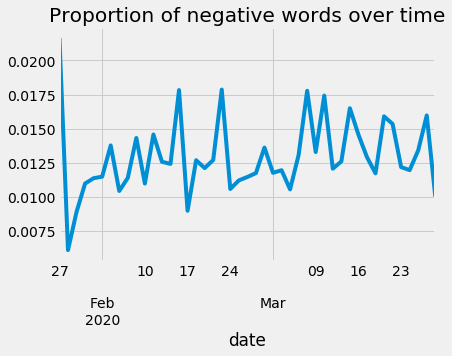

In [226]:
(over_time.Negative / over_time.word_count).plot(title="Proportion of negative words over time")

## Analyst Concerns

What concerns do analysts have?

In [ ]:
top_questions = questions[questions.apply(lambda x: x != "")].sample(n=10)
top_questions.name = "cv_questions"

In [ ]:
for _, row in df.join(top_questions, how="inner").iterrows():
    print(row["name"])
    print(row["cv_questions"])
    print()

In [ ]:
questions[questions.apply(lambda x: x != "")].sample

In [ ]:
print(df[questions.apply(lambda x: x != "")].iloc[104].prepared_remarks)

## Language

In [71]:
all_sentences = df[df.prepared_remarks_cv].prepared_remarks \
    .apply(lambda x: pd.Series(x.split("\n\n"))) \
    .stack() \
    .reset_index(level=1) \
    .rename(columns={"level_1": "sentence_number", 0: "text"}) \
    .reset_index()
all_sentences["cv"] = all_sentences.text.apply(lambda x: _has_coronavirus(x))

In [75]:
t = all_sentences.groupby("cv").agg({"text": lambda x: " ".join(x)})

In [77]:
t

,text
cv,
False,"Operator Hello, and welcome to the Scorpio Bul..."
True,"Yet again, geopolitical factors have impacted ..."


In [78]:
vec = TfidfVectorizer(stop_words="english")
X = vec.fit_transform(t.text)

<1x34623 sparse matrix of type '<class 'numpy.float64'>'
	with 9974 stored elements in Compressed Sparse Row format>

In [84]:
np.asarray(X[1].todense())

array([[0.00072565, 0.01509358, 0.        , ..., 0.00029026, 0.        ,
        0.        ]])

In [87]:
[vec.get_feature_names()[i] for i in np.asarray(X[1].todense()).flatten().argsort()[::-1][:20]]

['coronavirus',
 'year',
 'impact',
 'quarter',
 'million',
 '2020',
 'business',
 'china',
 'covid',
 'growth',
 'expect',
 '19',
 'outbreak',
 'situation',
 'guidance',
 'continue',
 'revenue',
 '2019',
 'sales',
 'market']

In [65]:
vec.get_feature_names()[]

'impact'

In [ ]:
questions = df.questions_and_answers

In [ ]:
cv_sentences = df.prepared_remarks[df.prepared_remarks_cv].apply(lambda x: " ".join([s for s in sent_tokenize(x) if _has_coronavirus(s)]))

In [ ]:
questions = df.questions_and_answers.apply(
    lambda x: " ".join([s for s in sent_tokenize(x) if _has_coronavirus(s) and s.endswith("?")]))

In [ ]:
vec = CountVectorizer(stop_words="english")
count_matrix = vec.fit_transform(questions[questions.apply(lambda x: x != "")])
feature_counts = dict(zip(vec.get_feature_names(), np.asarray(count_matrix.sum(axis=0)).flatten()))

In [ ]:
Counter(feature_counts).most_common()

In [ ]:
vec = CountVectorizer(stop_words="english")


In [ ]:
counts = vec.fit_transform(cv_sentences)
counts2 = vec2.fit_transform(cv_qa)

In [ ]:
counts_list = np.asarray(counts.sum(axis=0)).flatten()
counts_list2 = np.asarray(counts2.sum(axis=0)).flatten()

In [ ]:
count_dict = dict(zip(vec.get_feature_names(), counts_list))
count_dict2 = dict(zip(vec2.get_feature_names(), counts_list2))

In [ ]:
Counter(count_dict).most_common()

In [ ]:
Counter(count_dict2).most_common()

In [231]:
df[df.ticker.apply(lambda x: "AAPL" in x)]

,url,title,author,transcribed_date,description,top,prepared_remarks,questions_and_answers,call_participants,name,ticker,date,prepared_remarks_cv,questions_and_answers_cv,any_cv,quarter,ticker_split,Symbol,Name,Sector
251,https://www.fool.com/earnings/call-transcripts...,Apple Inc. (AAPL) Q1 2020 Earnings Call Transc...,Motley Fool Transcribers,"Jan 28, 2020",AAPL earnings call for the period ending Decem...,Image source: The Motley Fool.\n\nApple Inc. (...,Operator\n\nGood day everyone. Welcome to the ...,Operator\n\nYes. That will be from Amit Daryan...,"Tejas Gala -- Senior Analyst, Corporate Financ...",Apple Inc.,NASDAQ:AAPL,2020-01-28,True,True,True,Q1,AAPL,AAPL,Apple Inc.,Information Technology


In [ ]:
df["only_qa"] = df.questions_and_answers_cv & ~df.prepared_remarks_cv
only_qa_proportion = df.groupby("date").sum()
(only_qa_proportion["only_qa"] / only_qa_proportion["any_cv"]).plot()